In [22]:
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import SUITPy as suit
import Functional_Fusion.plot as plot


In [134]:
wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/thalamus'

atlas, _ = am.get_atlas('MNISymThalamus1')

atlas_fname = np.load(f"{wk_dir}/Prob_thalamus.npy")
comb_hemispheres = atlas_fname[0:16] + atlas_fname[16:32]   

print(atlas_fname.shape)

print(comb_hemispheres.shape)


(32, 25640)
(16, 25640)


In [56]:

ar_model = ar.build_arrangement_model(comb_hemispheres, prior_type='prob', atlas=atlas)



/Users/incehusain/Documents/GitHub/HierarchBayesParcel/HierarchBayesParcel/arrangements.py:1879: UserWarning: The marginal probability has 15267 voxels zero values - adding small value to avoid -inf
  warnings.warn(f'The marginal probability has {zero_voxl} voxels'


In [143]:
K = ar_model.K
P = atlas.P

U_flat = np.ones((K, P)) / K    

ar_model_flat = ar.build_arrangement_model(U_flat, prior_type='prob', atlas=atlas)


In [122]:
data_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion_new/MDTB'

# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')

data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/derivatives/ffextract/{s}/{s}_space-{atlas.name}_ses-s2_CondRun.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond (16 repetitions x 9 conditions) x numvoxel tensor
data = np.stack(data)
data.shape

(24, 512, 25640)

In [124]:
info = pd.read_csv(f'{data_dir}/derivatives/ffextract/sub-02/sub-02_ses-s2_CondRun.tsv',sep='\t')
cond_v = info['cond_code'].values #condition number
part_v = info['run'].values #number of runs 

cond_v

array(['task', 'nviolation', 'violation', 'scrambeled', 'generate',
       'read', 'task', 'easy', 'med', 'diff', 'nature', 'romance',
       'landscape', 'simple', 'sequence', 'easy', 'med', 'diff',
       '2bcknrep', '2bckrep', 'normal', 'scrambeled', 'easy', 'med',
       'diff', 'small', 'med', 'large', 'task', 'action', 'knot', 'task',
       'task', 'nviolation', 'violation', 'scrambeled', 'generate',
       'read', 'task', 'easy', 'med', 'diff', 'nature', 'romance',
       'landscape', 'simple', 'sequence', 'easy', 'med', 'diff',
       '2bcknrep', '2bckrep', 'normal', 'scrambeled', 'easy', 'med',
       'diff', 'small', 'med', 'large', 'task', 'action', 'knot', 'task',
       'task', 'nviolation', 'violation', 'scrambeled', 'generate',
       'read', 'task', 'easy', 'med', 'diff', 'nature', 'romance',
       'landscape', 'simple', 'sequence', 'easy', 'med', 'diff',
       '2bcknrep', '2bckrep', 'normal', 'scrambeled', 'easy', 'med',
       'diff', 'small', 'med', 'large', 'task

In [148]:
K = ar_model_flat.K

# Make a design matrix
X= ut.indicator(cond_v)

# Build an emission model
em_model = em.MixVMF(K=K,P=atlas.P, X=X,part_vec=part_v)

# Build the full model: The emission models are passed as a list, as usually we have multiple data sets
M = fm.FullMultiModel(ar_model_flat, [em_model])

# Attach the data to the model - this is done for speed
# The data is passed as a list with on element per data set

M.initialize([data])

# Now we can run the EM algorithm
M, _, _, _ = M.fit_em(iter=200, tol=0.01,
    fit_arrangement=False,fit_emission=False,first_evidence=False)


In [149]:
U_indiv,_ = M.Estep()
print(U_indiv.shape)

torch.Size([24, 16, 25640])


In [150]:

subj_info = pd.read_csv(f"{data_dir}/participants.tsv", sep="\t")
subjects = subj_info["participant_id"].tolist()

for y, subj in enumerate(subjects):
    np.save(f"{wk_dir}/indiv_parcellations/MDTB-ses2_flat/{subj}.npy",U_indiv[y])  


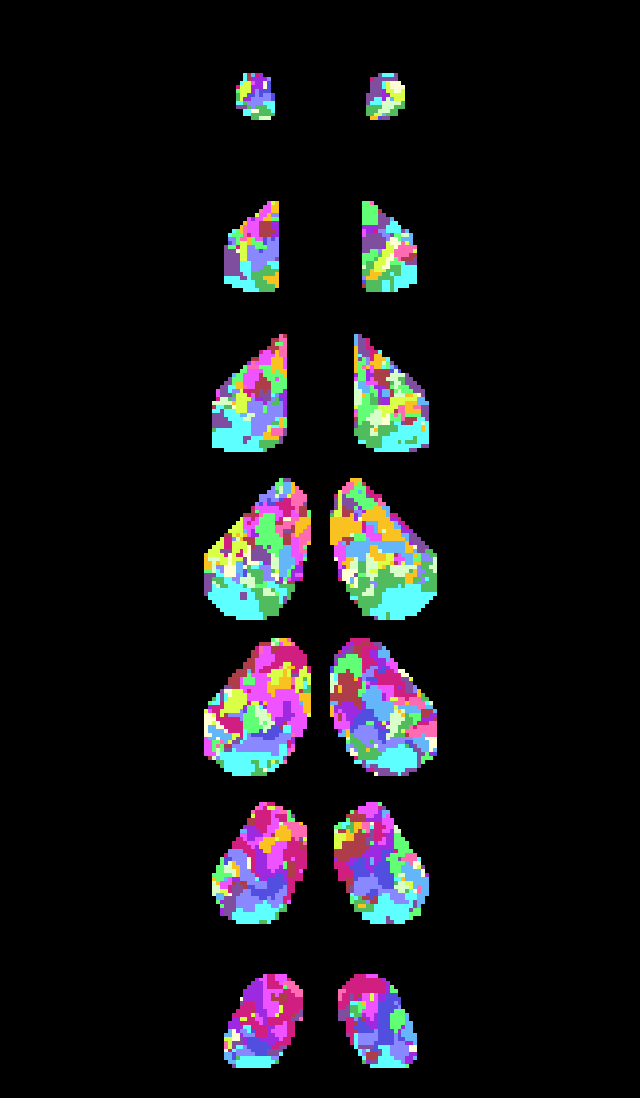

In [156]:
lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB-ses2/sub-22.npy")

wta = np.argmax(pmap, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)


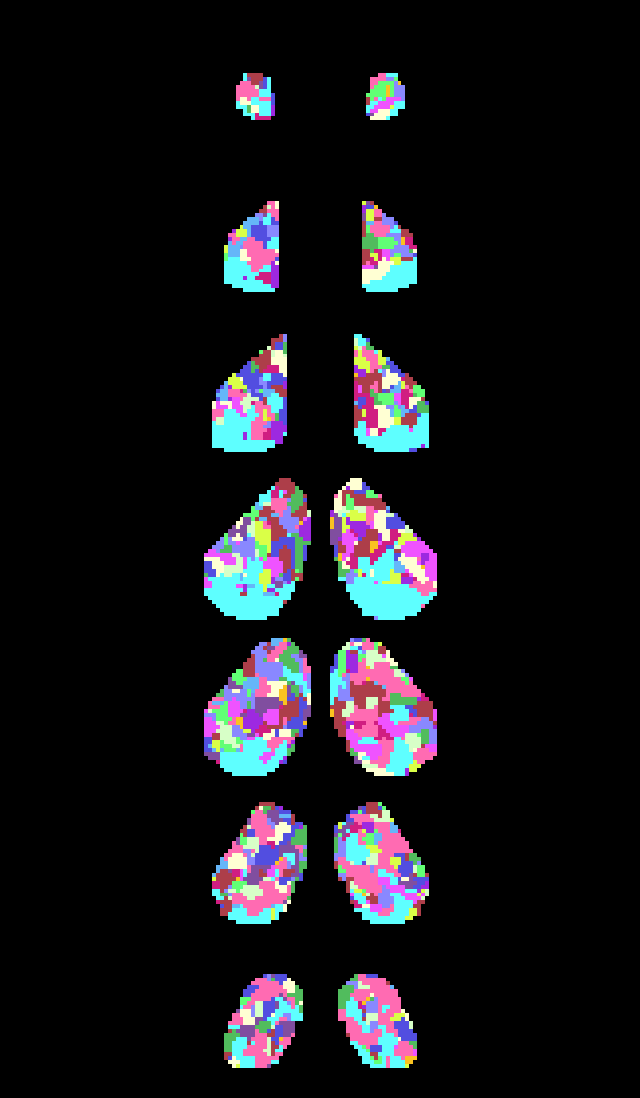

In [155]:
lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB-ses2_flat/sub-15.npy")

wta = np.argmax(pmap, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)


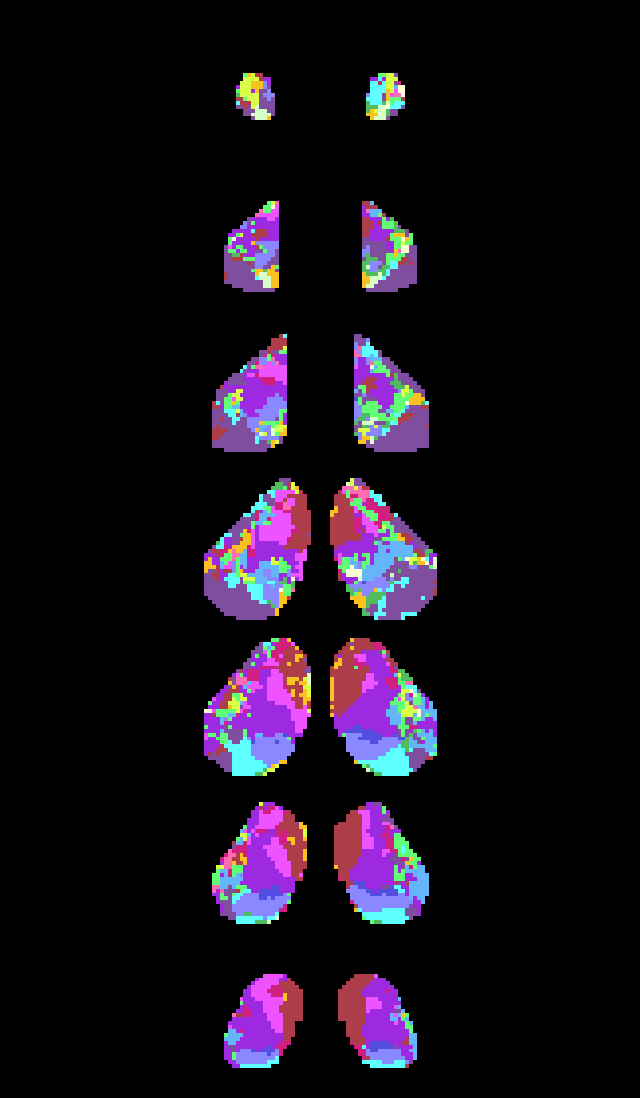

In [92]:
lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/Prob_thalamus.npy")
comb_hemispheres = pmap[0:16] + pmap[16:32]   

wta = np.argmax(comb_hemispheres, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)
